# Notes
We use a custom client that we haven't shared here (it is proprietary code). But you can use the [OpenAI API](https://platform.openai.com/docs/libraries/python-library) and it will yield the same results.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import json

#!!!!!!! Replace this with the OpenAI API
from llmclient import LLMClient 

%matplotlib inline
import matplotlib.font_manager
from matplotlib import rc

from scipy.stats import pearsonr
from tqdm import tqdm
import pandas as pd

from datasets import load_dataset
import re
fix_spaces = re.compile(r'\s*([?!.,]+(?:\s+[?!.,]+)*)\s*')


plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Data Collection
- Load TOEFL11 data from here (LDC registration required): https://catalog.ldc.upenn.edu/LDC2014T06
- Sample code for Wikitext103 and DailyMail included in this notebook.

In [7]:
wikitext_raw = load_dataset("wikitext", 'wikitext-103-v1')
dailymail_raw = load_dataset("ccdv/cnn_dailymail", '3.0.0')

wikitext = [p["text"] for p in wikitext_raw["train"] if len(p["text"].split(".")) > 4 and len(p["text"].split(". ")) < 25] # Keep only actual passages of tractable length
dailymail = [p["article"] for p in dailymail_raw["train"] if len(p["article"].split(". ")) > 4] # Lower here because we know it is a good corpus

merged_dataset = [fix_spaces.sub(lambda x: "{} ".format(x.group(1).replace(" ", "")), p) for p in wikitext + dailymail]


merged_dataset = [p for p in merged_dataset if len(p.split(". ")) > 8 and len(p.split(". ")) < 16]
print(len(merged_dataset))

# Sample data:
random.shuffle(merged_dataset)

160880


In [8]:
def get_meta_prompt(task, content):
    PA_prompt = ""
    PA_prompt += "$DOCUMENT"
    PA_prompt += "|Start of Instructions|\n"
    PA_prompt += "# Instructions:\n"
    PA_prompt += "- Suppose you are a teacher and would like to provide guidance on the writing. You have to give 5 prompts that lead to $TASK.\n"
    PA_prompt += "- Give 5 concrete and helpful prompts whose output improves the [Text].\n"
    PA_prompt += "- The prompts should be in a manner that works in the whole document.\n"
    PA_prompt += "- The prompts should be in a neutral tone and must talk about the text ONLY. They cannot be about grammar, punctuation, or anything like that.\n"
    PA_prompt += "- Try giving out some ideas based on context."
    PA_prompt += "- Here are some examples:\n"
    PA_prompt += "1) Talk more about [topic].\n"
    PA_prompt += "2) Tell me more about [topic].\n"
    PA_prompt += "3) Elaborate on the [topic] in the last paragraph.\n"
    PA_prompt += "4) Add a connecting sentence to make the transition [topic] smooth.\n"
    PA_prompt += "The [topic] is to be decided based on the text.\n"
    PA_prompt += "\n\n"
    PA_prompt += "# Output Format:\n"
    PA_prompt += "- Each output is a prompt.\n"
    PA_prompt += "- Make sure to give all 5 prompts.\n"
    PA_prompt += "- Give the prompts in a numbered list.\n"
    PA_prompt += "- NO extra text or additional arguments should be added to the prompts.\n"
    PA_prompt += "|End of Instructions|\n"
    PA_prompt += "Begin response\n"
    PA_prompt += "1)"
    PA_prompt = PA_prompt.replace("$DOCUMENT", content)
    PA_prompt = PA_prompt.replace("$TASK", task)
    return PA_prompt

creativity_task = "Write a paragraph to connect the left text and right text."
creativity_base_prompt_1 = ""
creativity_base_prompt_2 = "Insert a passage connecting the two passages."
creativity_base_prompt_3 = creativity_task

ideation_task = "Rewrite the passage in the [text] in a more creative way."
ideation_base_prompt_1 = "Make it more concise"
ideation_base_prompt_2 = "Explain this to a 5 year old"
ideation_base_prompt_3 = "Make it longer"


def ideation_document_fomatter(content, left, right):
    formatted_content = ""
    formatted_content += "# Input text:\n[previous context]:\n"
    formatted_content += left + "\n"
    formatted_content += "[Text]:\n" + content + "\n"
    formatted_content += "# [following context]:\n" + right
    formatted_content += "\n\n"
    return formatted_content


def creativity_document_fomatter(left_content, right_content):
    formatted_content = ""
    formatted_content = "# Input text:\n"
    formatted_content += "[Left Text] \n"
    formatted_content += left_content
    formatted_content += "\n[Right Text]\n" 
    formatted_content += right_content
    formatted_content += "\n\n"
    return formatted_content


# Replace this with an OpenAI API call

In [9]:
params = {"max_tokens": 512}
gpt4 = LLMClient(params, "GPT-4")

## Ideation
We have provided a toy implementation.
- In practice we called this multiple times until we had at least 6 outputs and 3 meta-prompts.
- We also had to handle throttling (too many requests will die on us!)
- This does not include TOEFL11 (but you can download it from LDC)

In [20]:
ideation_dataset = random.sample(merged_dataset, 2) # For demo.
ideation_points = []

for ix in tqdm(range(len(ideation_dataset))):

    passage = ideation_dataset[ix]

    # We'll also provide some context.
    split_passage = passage.split(". ")
    num_breaks = len(split_passage)
    context_len = 4
    index = random.randint(0, context_len)
    
    left = ". ".join(split_passage[:index]).strip()
    context = ". ".join(split_passage[index:index + context_len]).strip()
    right = ". ".join(split_passage[index + context_len:]).strip()

    processed_passage = ideation_document_fomatter(context, left, right)
    meta_prompt = get_meta_prompt(ideation_task, processed_passage)

    # Gather the prompts:
    response = gpt4.send_request(meta_prompt)
    prompts = [i for i in response["choices"][0]["text"].split("\n") if i[1] == ")"]

    if len(prompts) < 3:
        print("Index {} needs redoing!".format(ix))
        continue

    prompts = [i[2:].strip() for i in prompts][:3]
    prompts += [ideation_base_prompt_1, ideation_base_prompt_2, ideation_base_prompt_3]

    outputs = []
    # Gather the outputs
    for prompt in prompts:
        passage_and_prompt = processed_passage + "\n" + prompt
        response = gpt4.send_request(passage_and_prompt)
        output = response["choices"][0]["text"]
        # Handle super annoying GPT-4 boilerplate
        if output.startswith("\n\n"):
            output = "\n".join(output.split("\n\n")[2:]).strip()
        outputs.append(output)

    point = {"Passage": processed_passage,
             "Prompts": {"Prompt{}".format(i + 1): p for i, p in enumerate(prompts)},
             "Outputs": {"Output{}".format(i + 1): p for i, p in enumerate(outputs)},
             "Index": ix,
             "Metadata": {"Feature": "Ideation", "Type": type}
            }
    ideation_points.append(point)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [04:50<00:00, 145.21s/it]


In [21]:
for point in ideation_points:
    print("------------------")
    print("Passage (context is [Text])\n", point["Passage"])
    print("Suggested prompts (1-3 generated prompts, 4-6 baselines):\n", "\n-".join([v for k,v in point["Prompts"].items()]))
    print("\n")
    print("Sample Output 1:\n", point["Outputs"]["Output1"])

------------------
Passage (context is [Text])
 # Input text:
[previous context]:

[Text]:
Steinholt started her political career as a member of Red Youth, and later became a member of its mother party, Red. In 2007 Steinholt was elected as Red Nordland 's leading candidate in the local elections of 2007. Steinholt had a very short election campaign, but she managed to make several notable appearances. Steinholt focused on environmental issues during the campaign, and opposed the establishment of a petroleum plant in northern Norway
# [following context]:
Under her leadership, Red <unk> received 2 @, @ 956 votes, 3 @. @ 0 percent of the votes, an increase of 0 @. @ 9 % from the previous local election in 2003. Red won another seat on the Nordland County Council during the election ; Steinholt became the youngest member of the council.


Suggested prompts (1-3 generated prompts, 4-6 baselines):
 Instead of simply stating that you focused on environmental issues during the campaign, give

## Creativity
We have provided a toy implementation.
- In practice we called this multiple times until we had at least 6 outputs and 3 meta-prompts.
- We also had to handle throttling (too many requests will die on us!)
- This does not include TOEFL11 (but you can download it from LDC)

In [22]:
creativity_dataset = random.sample(merged_dataset, 2) # For demo.
creativity_points = []

for ix in tqdm(range(len(creativity_dataset))):

    passage = creativity_dataset[ix]

    # Randomly split on left, right, or both; with a slight preference to both.
    type = random.choice(["left", "right", "both", "both"])
    split_passage = passage.split(". ")
    num_breaks = len(split_passage)
    
    index = random.randint(4, num_breaks)
    max_passage_len = 8
    
    left = ". ".join(split_passage[:index]) if type in ["left", "both"] else ""
    right = "" if type == "left" else ". ".join(split_passage[index:min(max_passage_len + index, num_breaks)])

    processed_passage = creativity_document_fomatter(left, right)
    meta_prompt = get_meta_prompt(creativity_task, processed_passage)

    # Gather the prompts:
    response = gpt4.send_request(meta_prompt)
    prompts = [i for i in response["choices"][0]["text"].split("\n") if i[1] == ")"]

    if len(prompts) < 3:
        print("Index {} needs redoing!".format(ix))
        continue

    prompts = [i[2:].strip() for i in prompts][:3]
    prompts += [creativity_base_prompt_1, creativity_base_prompt_2, creativity_base_prompt_3]

    outputs = []
    # Gather the outputs
    for prompt in prompts:
        passage_and_prompt = processed_passage + "\n" + prompt
        response = gpt4.send_request(passage_and_prompt)
        output = response["choices"][0]["text"]
        # Handle super annoying GPT-4 boilerplate
        if output.startswith("\n\n"):
            output = "\n".join(output.split("\n\n")[2:]).strip()
        outputs.append(output)

    point = {"Passage": processed_passage,
             "Prompts": {"Prompt{}".format(i + 1): p for i, p in enumerate(prompts)},
             "Outputs": {"Output{}".format(i + 1): p for i, p in enumerate(outputs)},
             "Index": ix,
             "Metadata": {"Feature": "Creativity", "Type": type}
            }
    creativity_points.append(point)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [04:31<00:00, 135.52s/it]


In [23]:
for point in creativity_points:
    print("------------------")
    print("Passage\n", point["Passage"])
    print("Suggested prompts (1-3 generated prompts, 4-6 baselines):\n", "\n-".join([v for k,v in point["Prompts"].items()]))
    print("\n")
    print("Sample Output 1:\n", point["Outputs"]["Output1"])

------------------
Passage
 # Input text:
[Left Text] 

[Right Text]
He says Bale is " electrifying, " evoking Al Pacino in The Godfather Part II, that Eckhart 's portrayal of Harvey Dent is " scarily moving ", and that Oldman " is so skilled that he makes virtue exciting as Jim Gordon ". Travers says Ledger moves the Joker away from Jack Nicholson 's interpretation into darker territory, and expresses his support for any potential campaign to have Ledger nominated for an Academy Award, Travers says that the filmmakers move the film away from comic book cinema and closer to being a genuine work of art, citing Nolan 's direction and the " gritty reality " of Wally Pfister 's cinematography as helping to create a universe that has something " raw and elemental " at work within it. In particular, he cites Nolan 's action choreography in the IMAX @-@ tailored heist sequence as rivaling that of Heat ( 1995 ). Manohla Dargis of The New York Times wrote " Pitched at the divide between art and

# Annotation/Data Evaluation
- Uses the annotator raw data (so slightly different than yours)
- We originally called Creativity "Assistance"
- Due to a bug, there might be in the annotations 8 entries.
   - We pick the first 3 baselines and 3 meta-generated prompts, unless there are blanks.
- CI measurement is at the end of this section.

In [14]:
def get_avg_rankings(arr, feature="Assistance", anno=None):
    prompt_rankings = [[0 for _ in range(6)] for _ in range(6)]
    outcome_rankings = [[0 for _ in range(6)] for _ in range(6)]        
    p_rank1s=[[] for i in range(6)]#6---N*6
    o_rank1s=[[] for i in range(6)]#6---N*6    
    prompt_rankings_per_annotator = {"A{}".format(i): [] for i in range(3)}
    outcome_rankings_per_annotator = {"A{}".format(i): [] for i in range(3)}
    p_times_top_3 = [0 for _ in range(6)]
    o_times_top_3 = [0 for _ in range(6)]

    p_count, o_count = 0, 0
    print('len',len(arr))
    for point in arr:#300 dp#
        for a, annoname in enumerate(point["Annotators"][0].keys()):#
            if anno is not None:
                if a != anno:
                    continue
            apoint = point["Annotators"][0][annoname]
            rankings = apoint["PromptRanking"]
            if feature == "Assistance" and "PromptRanking7" in rankings:
                continue

            for p,v in rankings.items():
                p_index = int(p[-1])
                p_value = 0
                if feature == "Ideation":
                    if p_index in [0, 7]:
                        continue
                p_value = int(v) - 1 # Zero-indexed
                p_index = p_index - 1
                prompt_rankings[p_index][p_value] += 1
                p_rank1s[p_index].append(p_value)
                p_count += 1
                if p_value > 3:  # highest is six
                    p_times_top_3[p_index] += 1
                tmp = [0 for _ in range(6)]
                tmp[p_value] += 1
                prompt_rankings_per_annotator["A{}".format(a)].append(tmp)

            rankings = apoint["OutcomeRanking"]
            for p,v in rankings.items():
                p_index = int(p[-1])
                p_value = 0
                if feature == "Ideation":
                    if p_index in [0, 7]:
                        continue
                p_value = int(v) - 1
                p_index = p_index - 1
                outcome_rankings[p_index][p_value] += 1
                o_rank1s[p_index].append(p_value)
                o_count += 1
                if p_value > 3:
                    o_times_top_3[p_index] += 1
                tmp = [0 for _ in range(6)]
                tmp[p_value] += 1
                prompt_rankings_per_annotator["A{}".format(a)].append(tmp)

    prompt_rankings = [[p*100/p_count for p in arr] for arr in prompt_rankings]
    outcome_rankings = [[p*100/o_count for p in arr] for arr in outcome_rankings]
    p_rank1s = np.asarray(p_rank1s)
    o_rank1s = np.asarray(o_rank1s)

    print("Prompts: percentages of times it was top 3:")
    for i, p in enumerate(p_times_top_3):
        print("{} : {}%".format(i, round(p*100/(6*len(arr)))))
    print("Outputs: percentages of times it was top 3:")
    for i, p in enumerate(o_times_top_3):
        print("{} : {}%".format(i, round(p*100/(6*len(arr)))))
    
    return p_rank1s, o_rank1s

from scipy import stats
from scipy.stats import mannwhitneyu

def do_one_test(arr):
    #merge 0,1,2//，3，4，5
    one=np.mean(arr[:3,:],axis=0)
    two=np.mean(arr[3:,:],axis=0)
    new_data_j=one-two
    all_zeros=[0 for i in range(len(new_data_j))]
    p_v=stats.wilcoxon(one,two).pvalue
    print(p_v)

def do_sig_test(arr):
    sig_scores=[[0.0 for i in range(len(arr))] for j in range(len(arr))]
    total_series=len(arr)
    for i in range(total_series):
        for j in range(total_series):
            if i==j:continue
            data_i=arr[i]
            data_j=arr[j]
            new_data_j=data_i-data_j
            all_zeros=[0 for i in range(len(new_data_j))]
            p_v=stats.wilcoxon(new_data_j, all_zeros).pvalue
            sig_scores[i][j]=p_v
    x=np.asarray(sig_scores)

def do_plots(arr, feature="Assistance", anno=None):
    prompt_rankings = [[0 for _ in range(6)] for _ in range(6)]
    outcome_rankings = [[0 for _ in range(6)] for _ in range(6)]        
    
    prompt_rankings_per_annotator = {"A{}".format(i): [] for i in range(3)}
    outcome_rankings_per_annotator = {"A{}".format(i): [] for i in range(3)}

    p_times_top_3 = [0 for _ in range(6)]
    o_times_top_3 = [0 for _ in range(6)]
    
    p_count, o_count = 0, 0
    for point in arr:
        for a, annoname in enumerate(point["Annotators"][0].keys()):
            if anno is not None:
                if a != anno:
                    continue
            apoint = point["Annotators"][0][annoname]
            rankings = apoint["PromptRanking"]
            if feature == "Assistance" and "PromptRanking7" in rankings:
                # We had a bit of an issue with extra fields for annotators. Oops.
                continue

            for p,v in rankings.items():
                p_index = int(p[-1])
                p_value = 0
                if feature == "Ideation":
                    if p_index in [0, 7]:
                        continue
                p_value = int(v) - 1 # Zero-indexed
                p_index = p_index - 1
                prompt_rankings[p_index][p_value] += 1
                p_count += 1

                if p_value > 3:
                    p_times_top_3[p_index] += 1

                tmp = [0 for _ in range(6)]
                tmp[p_value] += 1
                prompt_rankings_per_annotator["A{}".format(a)].append(tmp)

            rankings = apoint["OutcomeRanking"]
            for p,v in rankings.items():
                p_index = int(p[-1])
                p_value = 0
                if feature == "Ideation":
                    if p_index in [0, 7]:
                        continue
                p_value = int(v) - 1
                p_index = p_index - 1
                outcome_rankings[p_index][p_value] += 1
                o_count += 1
                if p_value > 3:
                    o_times_top_3[p_index] += 1
                
                tmp = [0 for _ in range(6)]
                tmp[p_value] += 1
                prompt_rankings_per_annotator["A{}".format(a)].append(tmp)

    prompt_rankings = [[p*100/p_count for p in arr] for arr in prompt_rankings]
    outcome_rankings = [[p*100/o_count for p in arr] for arr in outcome_rankings]
    print("Prompt ---->")
    for row in prompt_rankings:
        print([round(r, 2) for r in row])

    print("")
    print("Prompt ---->")
    for row in outcome_rankings:
        print([round(r, 2) for r in row])

    prompt_rankings = np.array(prompt_rankings)
    outcome_rankings = np.array(outcome_rankings)
    ticks = range(6)
    pref_ticks = [str(i) for i in range(1, 7)]
    pref_ticks[0] = "(worst) " + pref_ticks[0]
    pref_ticks[-1] = "(best) " + pref_ticks[-1]
    
    prompt_ticks = [str(i) for i in range(1, 7)]
    prompt_ticks[-3] = "* " + prompt_ticks[-3]
    prompt_ticks[-2] = "* " + prompt_ticks[-2]
    prompt_ticks[-1] = "* " + prompt_ticks[-1]    
    
    plt.imshow(prompt_rankings, cmap="gist_heat_r")
    plt.title("Prompt Suitability ({})".format(feature))
    plt.xlabel("Prompts")
    plt.yticks(ticks, labels=pref_ticks)
    plt.xticks(ticks, labels=prompt_ticks)
    plt.ylabel("Suitability")
    plt.colorbar()
    plt.show()

    plt.title("Outcome Suitability ({})".format(feature))
    plt.imshow(outcome_rankings, cmap="GnBu")
    plt.xlabel("Outcomes")
    plt.ylabel("Suitability")
    plt.yticks(ticks, labels=pref_ticks)
    plt.xticks(ticks, labels=prompt_ticks)
    plt.colorbar()
    plt.show()

In [15]:
annotated_ideation = json.load(open("Ideation300.json", "r", encoding="utf-8"))
annotated_assistance = json.load(open("Assistance300.json", "r", encoding="utf-8"))

# Do the plots

Prompt ---->
[3.29, 0.84, 2.23, 2.66, 3.06, 4.59]
[0.82, 1.37, 1.77, 3.14, 4.66, 4.91]
[1.69, 1.5, 3.22, 3.1, 3.79, 3.37]
[2.57, 1.98, 2.95, 3.39, 2.87, 2.91]
[5.02, 4.49, 3.29, 2.09, 1.29, 0.48]
[3.25, 6.51, 3.23, 2.26, 0.99, 0.42]

Prompt ---->
[3.39, 1.79, 2.4, 2.8, 2.95, 3.35]
[1.85, 2.13, 2.28, 2.93, 3.69, 3.79]
[2.51, 2.3, 2.66, 2.61, 3.31, 3.27]
[2.82, 2.95, 2.42, 2.91, 2.45, 3.12]
[2.51, 4.15, 3.39, 2.66, 2.17, 1.79]
[3.56, 3.39, 3.52, 2.78, 2.09, 1.33]


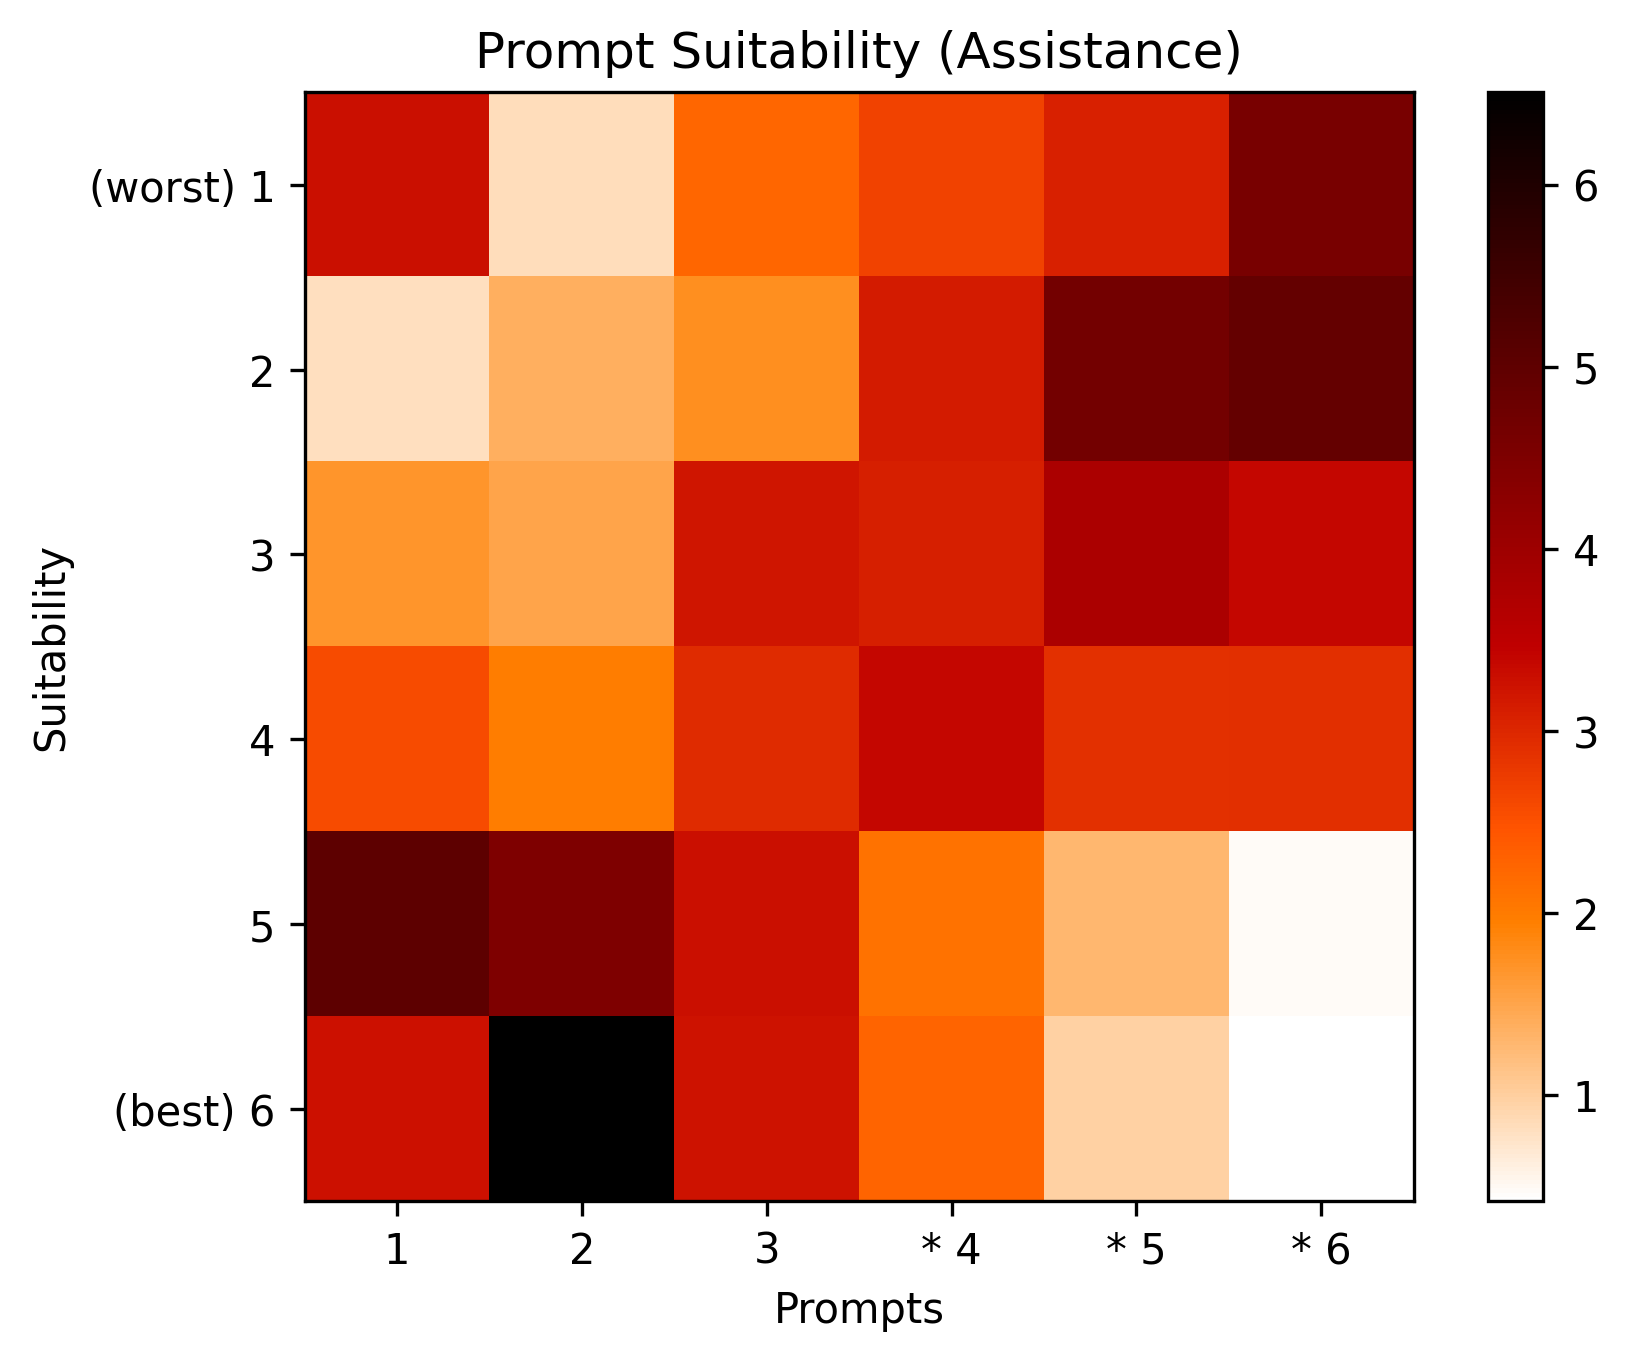

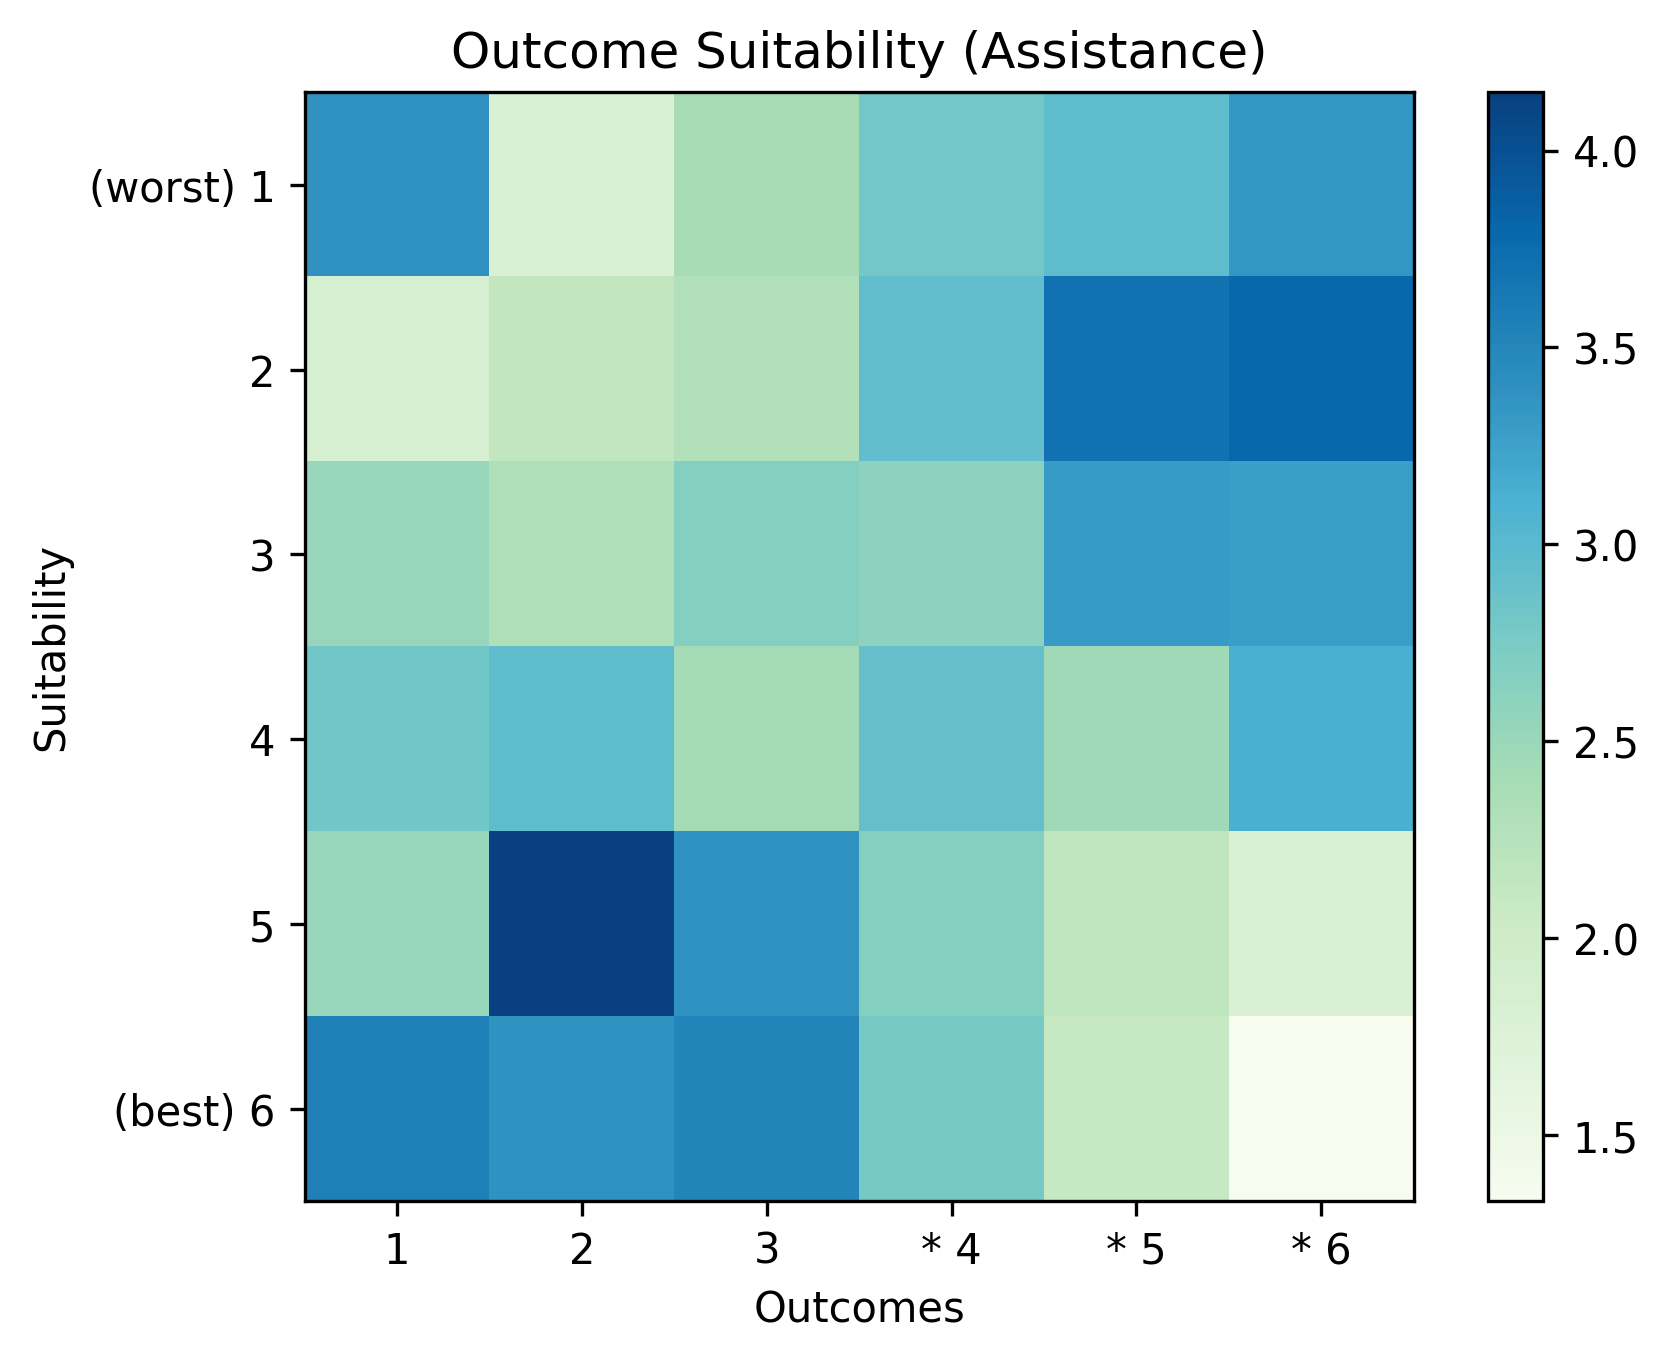

In [16]:
do_plots(annotated_assistance, feature="Assistance")

Prompt ---->
[0.26, 3.5, 2.76, 2.24, 3.56, 4.35]
[0.13, 3.26, 2.67, 2.48, 3.19, 4.94]
[0.13, 3.37, 3.04, 2.89, 3.11, 4.13]
[0.06, 2.96, 4.22, 4.5, 3.39, 1.54]
[15.91, 0.63, 0.07, 0.0, 0.02, 0.04]
[0.17, 2.94, 3.93, 4.57, 3.41, 1.65]

Prompt ---->
[0.93, 3.06, 2.91, 2.69, 2.98, 4.11]
[0.74, 2.63, 3.02, 3.0, 3.39, 3.89]
[1.02, 3.13, 2.93, 3.48, 2.91, 3.2]
[0.11, 4.0, 5.09, 4.11, 2.11, 1.24]
[13.26, 2.43, 0.8, 0.04, 0.11, 0.04]
[0.59, 1.44, 1.93, 3.35, 5.19, 4.17]


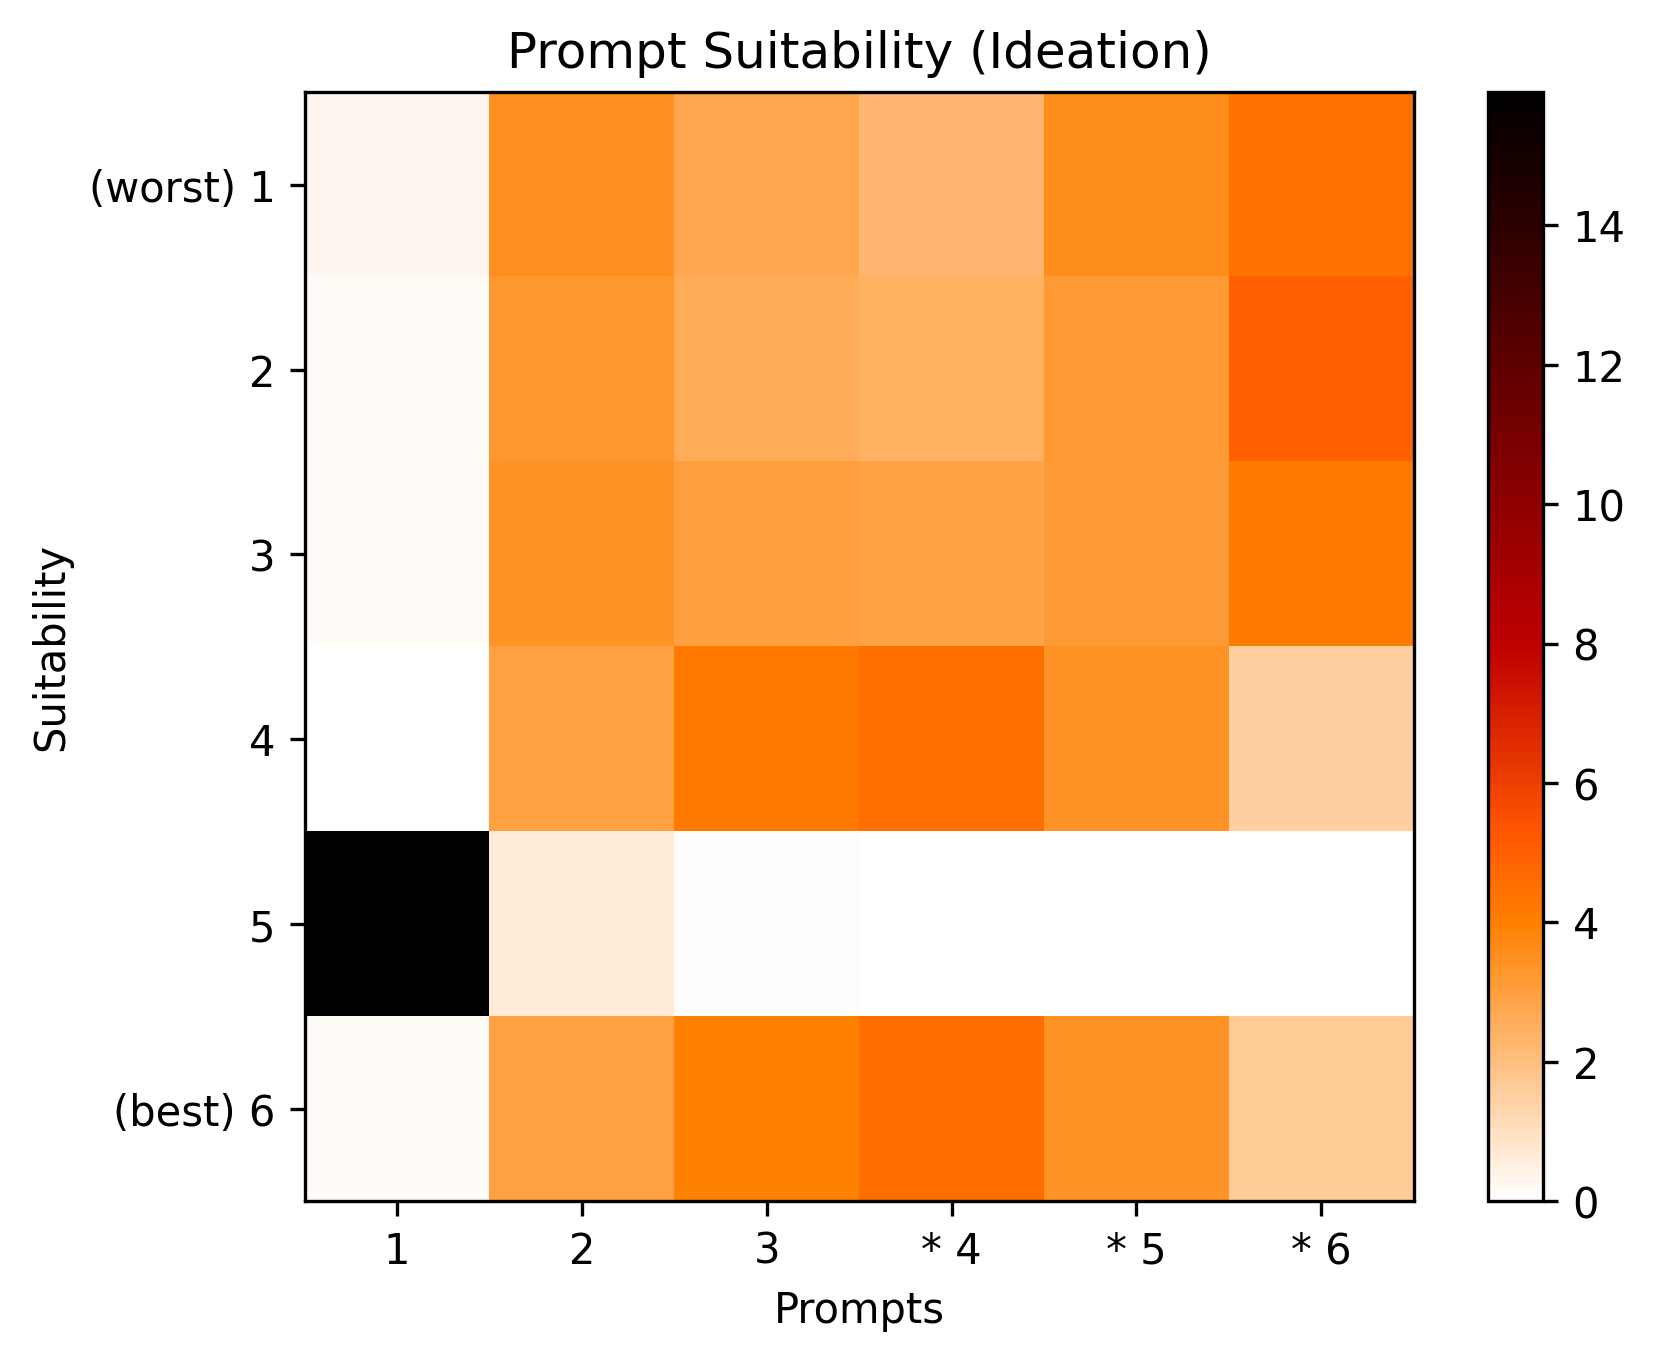

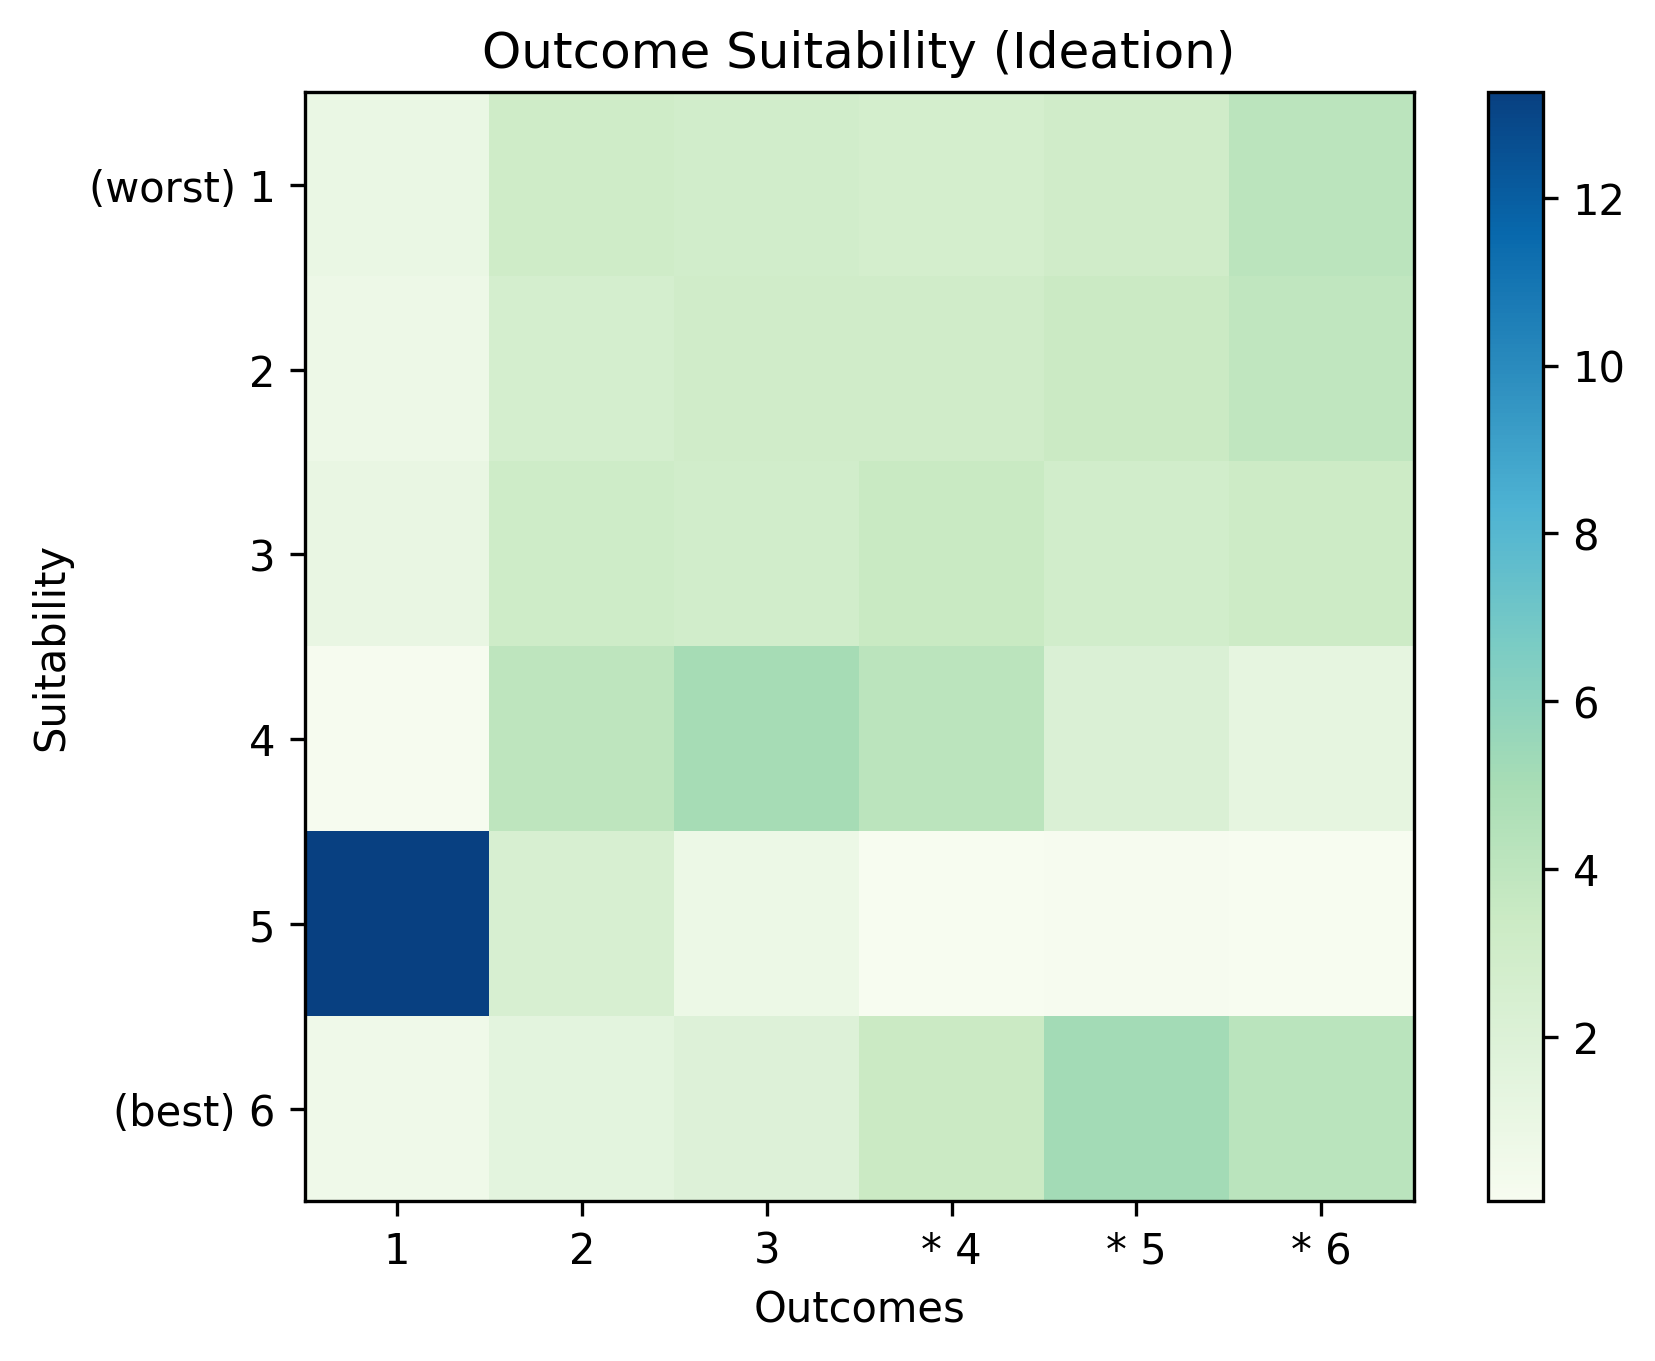

In [17]:
do_plots(annotated_ideation, feature="Ideation")

# Get CI

In [18]:
p_rank1s, o_rank1s = get_avg_rankings(annotated_assistance, feature="Assistance")
print('assistance')
print('out')
do_one_test(o_rank1s)
print('prompts')
do_one_test(p_rank1s)

len 300
Prompts: percentages of times it was top 3:
0 : 22%
1 : 28%
2 : 21%
3 : 17%
4 : 5%
5 : 4%
Outputs: percentages of times it was top 3:
0 : 18%
1 : 22%
2 : 19%
3 : 16%
4 : 12%
5 : 10%
assistance
out
3.864252143490793e-18
prompts
3.435204295998042e-81


In [19]:
p_rank1s,o_rank1s=get_avg_rankings(annotated_ideation, feature="Ideation")
print('Ideation')
print('out')
do_one_test(o_rank1s)
print('prompts')
do_one_test(p_rank1s)

len 300
Prompts: percentages of times it was top 3:
0 : 24%
1 : 24%
2 : 22%
3 : 15%
4 : 0%
5 : 15%
Outputs: percentages of times it was top 3:
0 : 21%
1 : 22%
2 : 18%
3 : 10%
4 : 0%
5 : 28%
Ideation
out
1.318353280242947e-72
prompts
9.410786113388541e-117
